In [38]:
import pandas as pd

dataset=pd.read_csv("D:\\sem 5\\INT246\\Dataset\\dataframe_hrv.csv")
print(dataset.shape)

# As you can see the no. of row is very high. So, i will take only rows in which 
# the stress value is distinct.
unique_dataset=dataset.drop_duplicates(subset=['stress'])
print(unique_dataset.shape)

# here, i am trying to check no. of unique values in each rows
print(unique_dataset[:].nunique())

(4129, 23)
(349, 23)
ECG                    349
EMG                    287
HR                     341
RESP                   349
Seconds                349
footGSR                349
handGSR                342
interval in seconds    192
marker                 292
newtime                349
time                   349
NNRR                    21
AVNN                   187
SDNN                   192
RMSSD                  146
pNN50                   70
TP                     322
ULF                    307
VLF                     49
LF                      17
HF                      17
LF_HF                   16
stress                 349
dtype: int64


In [39]:
# i am droping the rows whoes unique count is very less and which are not useful to me
unique_dataset=unique_dataset.drop(['AVNN','RMSSD','TP','ULF','time'], axis = 1)
unique_dataset=unique_dataset.drop(['NNRR','pNN50','VLF','LF','HF','LF_HF'], axis = 1)
unique_dataset=unique_dataset.drop(['Seconds','interval in seconds','marker','newtime','SDNN'], axis = 1)
unique_dataset.shape

(349, 7)

In [40]:
unique_dataset.head()

,ECG,EMG,HR,RESP,footGSR,handGSR,stress
0,-0.001974,-0.004737,77.815789,10.801842,2.417132,10.889447,0.000000
33,0.014367,-0.005082,92.204082,11.324327,2.972510,21.279490,0.693878
34,0.064320,-0.007940,168.840000,11.365840,3.692560,22.325800,1.000000
41,-0.004500,-0.004739,119.586956,11.295217,3.038087,19.277522,0.826087
42,-0.028045,-0.004273,120.227273,11.340136,2.943091,19.122523,0.431818


In [42]:
# convert few readings from float to int to make ANFIS fast
unique_dataset['HR']=unique_dataset['HR'].astype(int)
unique_dataset['RESP']=unique_dataset['RESP'].astype(int)
unique_dataset['footGSR']=unique_dataset['footGSR'].astype(int)
unique_dataset['handGSR']=unique_dataset['handGSR'].fillna(0).astype(int)
unique_dataset.head()

,ECG,EMG,HR,RESP,footGSR,handGSR,stress
0,-0.001974,-0.004737,77,10,2,10,0.000000
33,0.014367,-0.005082,92,11,2,21,0.693878
34,0.064320,-0.007940,168,11,3,22,1.000000
41,-0.004500,-0.004739,119,11,3,19,0.826087
42,-0.028045,-0.004273,120,11,2,19,0.431818


In [50]:
min_value=list(unique_dataset.min().values)
min_value # getting min value to calculate mf

[-0.07376595700000001, -0.012, 56.0, -12.0, 1.0, -28.0, 0.0]

In [53]:
max_value=list(unique_dataset.max().values) 
max_value

[0.631428571, 5.963230769, 249.0, 47.0, 21.0, 28.0, 1.0]

In [46]:
diff=list((unique_dataset.max().values-unique_dataset.min().values)/3) # to find diff for guassmf
diff

[0.2350648426666667,
 1.9917435896666664,
 64.33333333333333,
 19.666666666666668,
 6.666666666666667,
 18.666666666666668,
 0.3333333333333333]

In [57]:
# here i am only taking (HR RESP handGSR) variable for anfis because ANFIS is slow
# making 3 membership function for each variables
import numpy as np

mf=[]
column=unique_dataset.columns
loop=[2,3,5] #(HR RESP handGSR)
for i in loop:
    temp=[]
    low=min_value[i]
    high=min_value[i]+diff[i]
    for j in range(3):
        temp.append(['gaussmf',{'mean':(low+high)/2,'sigma':diff[i]/3}])
        low+=diff[i]
        high+=diff[i]
    mf.append(temp)

for i in range(3):
    print("Membership function for ",column[loop[i]])
    for j in range(3):
        print(mf[i][j])
    print()

Membership function for  HR
['gaussmf', {'mean': 88.16666666666666, 'sigma': 21.444444444444443}]
['gaussmf', {'mean': 152.5, 'sigma': 21.444444444444443}]
['gaussmf', {'mean': 216.83333333333331, 'sigma': 21.444444444444443}]

Membership function for  RESP
['gaussmf', {'mean': -2.166666666666666, 'sigma': 6.555555555555556}]
['gaussmf', {'mean': 17.5, 'sigma': 6.555555555555556}]
['gaussmf', {'mean': 37.16666666666667, 'sigma': 6.555555555555556}]

Membership function for  handGSR
['gaussmf', {'mean': -18.666666666666664, 'sigma': 6.222222222222222}]
['gaussmf', {'mean': 1.7763568394002505e-15, 'sigma': 6.222222222222222}]
['gaussmf', {'mean': 18.66666666666667, 'sigma': 6.222222222222222}]



Plot of Membership function for  HR


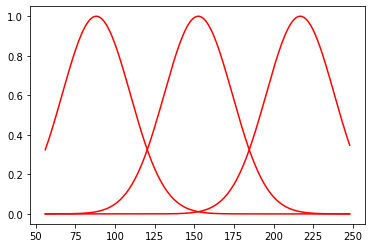

Plot of Membership function for  RESP


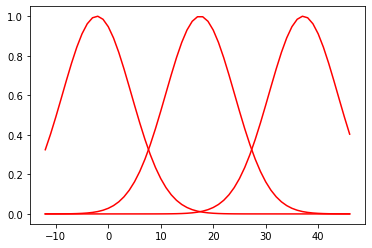

Plot of Membership function for  handGSR


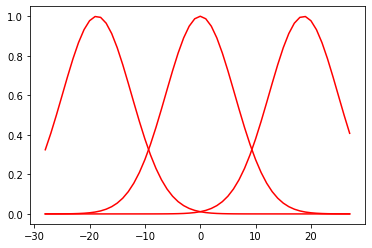

In [58]:
import anfis
from anfis.membership import mfDerivs
from anfis.membership import membershipfunction
from anfis.anfis import ANFIS

mfc = membershipfunction.MemFuncs(mf) # making mfc

X=unique_dataset[['HR','RESP','handGSR']] # training dataset 
X=X.iloc[:200,:] # here, no of column should be atleast 50 for correct training
Y=unique_dataset.iloc[:200,6] # stress column

anf = ANFIS(X, Y, mfc)

# plotting all membership functions

for i in range(len(loop)):
    print("Plot of Membership function for ",column[loop[i]])
    anf.plotMF(np.arange(min_value[loop[i]],max_value[loop[i]]),i)

current error:  13.331389424532244
0.2164761182767746
[13.33138942]
current error:  13.331218258240273
0.21647609528218406
[13.33138942 13.33121826]
current error:  13.331046824091574
0.216476103055205
[13.33138942 13.33121826 13.33104682]
current error:  13.33087508928102
0.21647607123518553
[13.33138942 13.33121826 13.33104682 13.33087509]
current error:  13.330685900152327
0.21647608247355912
[13.33138942 13.33121826 13.33104682 13.33087509 13.3306859 ]
current error:  13.330477398047337
0.21647607081612322
[13.33138942 13.33121826 13.33104682 13.33087509 13.3306859  13.3304774 ]
current error:  13.330247599992461
0.21647605765781108
[13.33138942 13.33121826 13.33104682 13.33087509 13.3306859  13.3304774
 13.3302476 ]
current error:  13.329994277837983
0.2164760435307636
[13.33138942 13.33121826 13.33104682 13.33087509 13.3306859  13.3304774
 13.3302476  13.32999428]
current error:  13.329714960542585
0.21647604468891538
[13.33138942 13.33121826 13.33104682 13.33087509 13.3306859  1

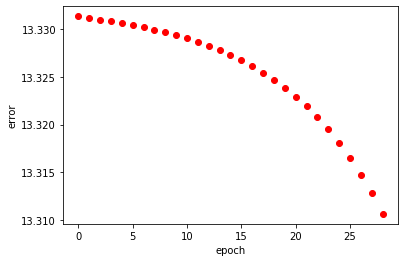

Plotting results


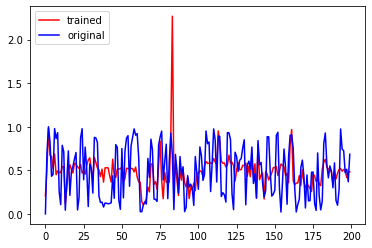

In [59]:
anf.trainHybridJangOffLine(epochs=30)

print("Plotting errors")
anf.plotErrors()
print("Plotting results")
anf.plotResults()

current error:  0.11848123202428491
0.0782519391032415
[0.11848123]
current error:  0.11840780736815051
0.078236994385807
[0.11848123 0.11840781]
Plotting errors


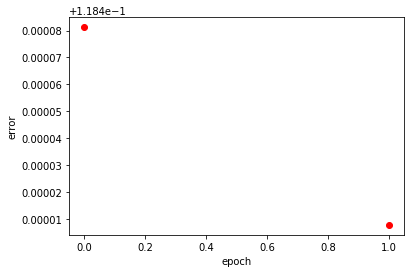

Plotting results


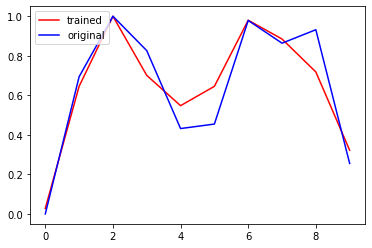

current error:  0.6400962845582577
0.11667020291542665
[0.64009628]
current error:  0.6400790066889275
0.11666877738400064
[0.64009628 0.64007901]
Plotting errors


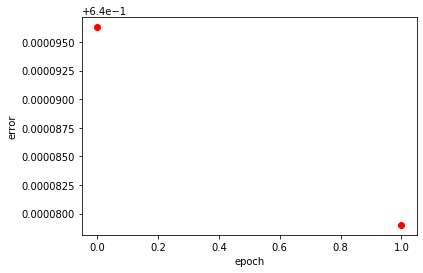

Plotting results


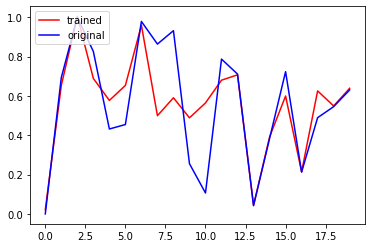

current error:  1.6345988373584037
0.1795434780521311
[1.63459884]
current error:  1.6345973889322116
0.17954420132454751
[1.63459884 1.63459739]
Plotting errors


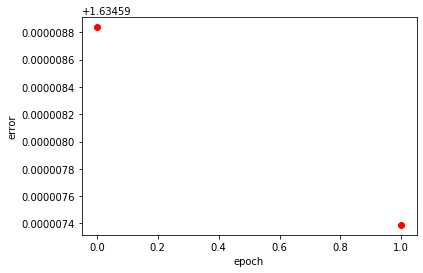

Plotting results


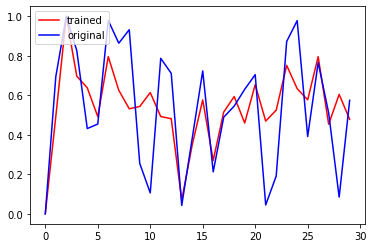

current error:  2.3528274162936347
0.1879032854759456
[2.35282742]
current error:  2.3528641065909985
0.18790655692524735
[2.35282742 2.35286411]
Plotting errors


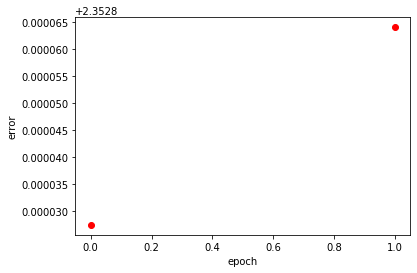

Plotting results


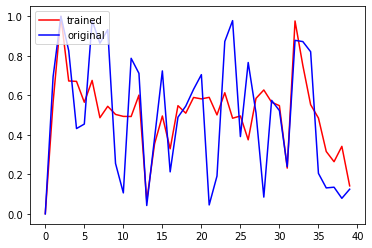

current error:  3.1678832702911026
0.2042746123494941
[3.16788327]
current error:  3.1678224443793854
0.20425399934900987
[3.16788327 3.16782244]
Plotting errors


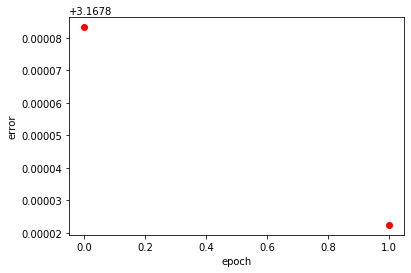

Plotting results


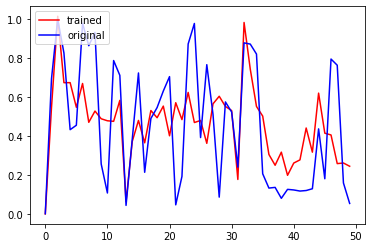

current error:  4.83008300763661
0.24401432360947825
[4.83008301]
current error:  4.83001358545582
0.24401202094827976
[4.83008301 4.83001359]
Plotting errors


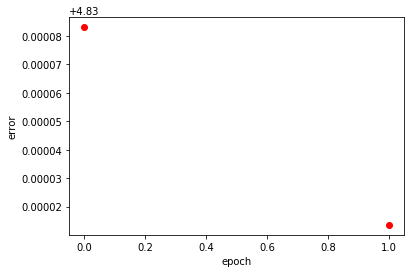

Plotting results


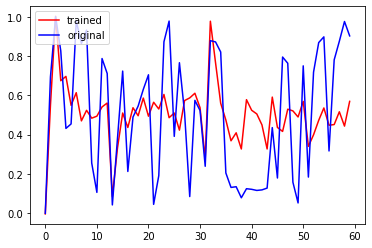

current error:  5.317949319264958
0.22967380072985116
[5.31794932]
current error:  5.317948250992847
0.2296714133710439
[5.31794932 5.31794825]
Plotting errors


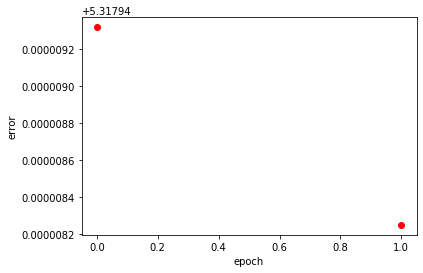

Plotting results


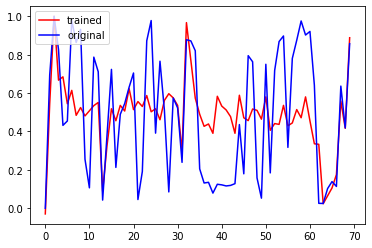

current error:  5.906443004715806
0.22870120409138311
[5.906443]
current error:  5.9064386509697275
0.22870262209969844
[5.906443   5.90643865]
Plotting errors


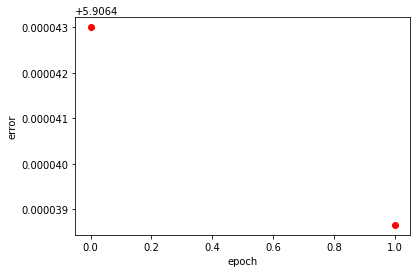

Plotting results


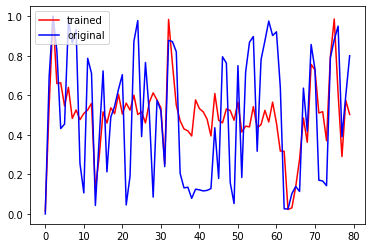

current error:  6.248375846050266
0.2147566840432602
[6.24837585]
current error:  6.2482263805960745
0.21475513115997685
[6.24837585 6.24822638]
Plotting errors


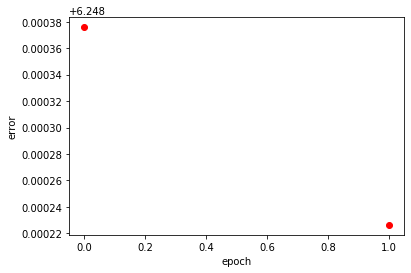

Plotting results


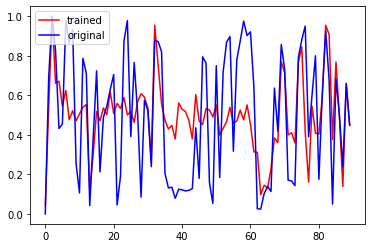

current error:  6.522969292357428
0.20984634723694362
[6.52296929]
current error:  6.522579178409179
0.20984004620282534
[6.52296929 6.52257918]
Plotting errors


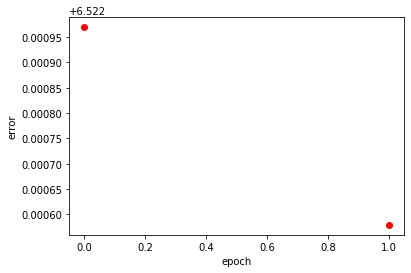

Plotting results


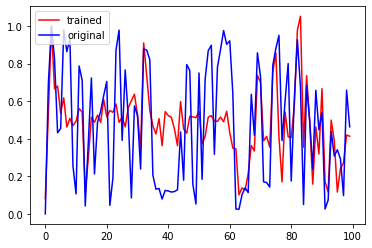

current error:  6.971528094272317
0.20399749123371638
[6.97152809]
current error:  6.971354191570949
0.2039928683558495
[6.97152809 6.97135419]
Plotting errors


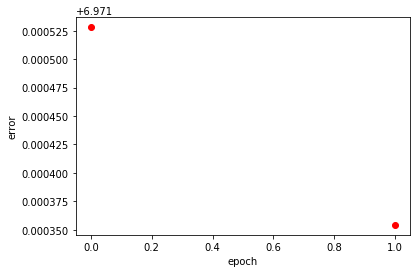

Plotting results


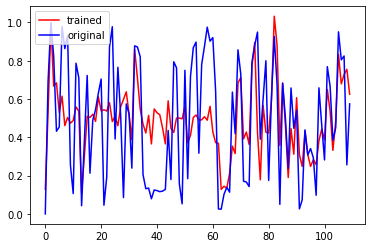

current error:  8.042547573811316
0.215491596001189
[8.04254757]
current error:  8.042300836118638
0.21548642916069025
[8.04254757 8.04230084]
Plotting errors


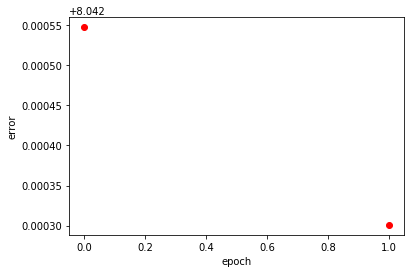

Plotting results


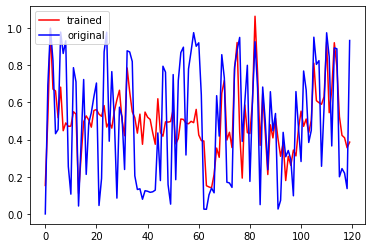

current error:  8.629504655245475
0.2148875042471512
[8.62950466]
current error:  8.624512497222085
0.21482430558426432
[8.62950466 8.6245125 ]
Plotting errors


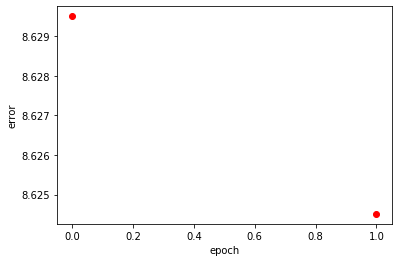

Plotting results


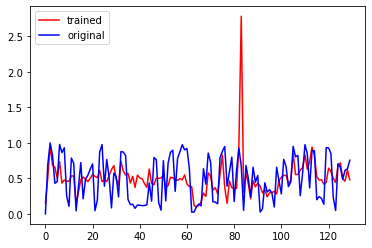

current error:  9.218698710224416
0.21383205347348555
[9.21869871]
current error:  9.218224962728424
0.21382434211197957
[9.21869871 9.21822496]
Plotting errors


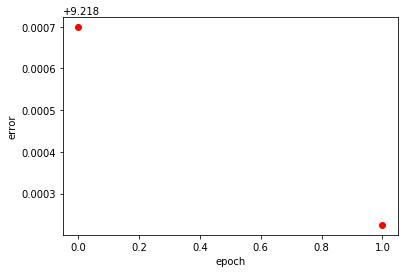

Plotting results


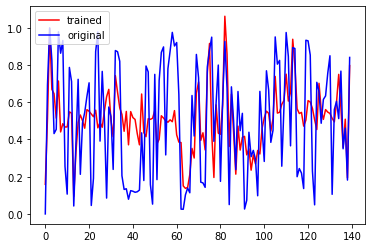

current error:  9.948014184133783
0.21633833892186946
[9.94801418]
current error:  9.94665870569591
0.21633525240984763
[9.94801418 9.94665871]
Plotting errors


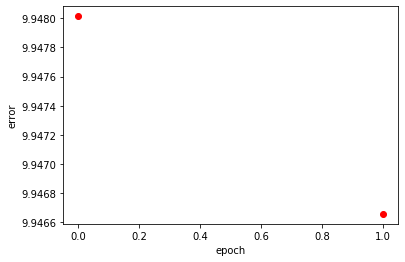

Plotting results


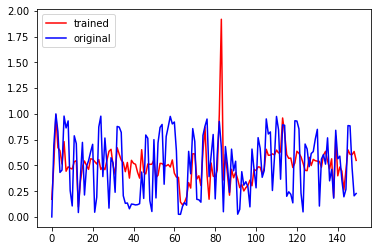

current error:  10.721718741872985
0.21654567772459385
[10.72171874]
current error:  10.721147273228748
0.21654169719350286
[10.72171874 10.72114727]
Plotting errors


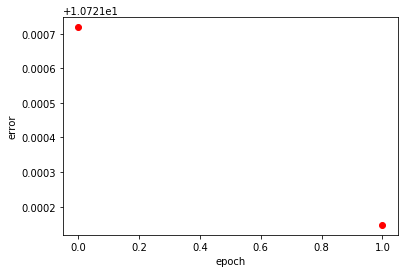

Plotting results


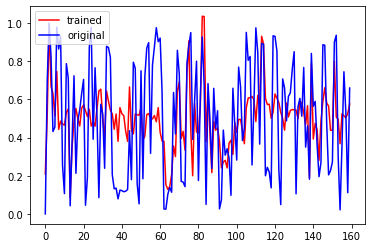

current error:  11.624696191128443
0.22001426658746695
[11.62469619]
current error:  11.62446113665516
0.22001407827022165
[11.62469619 11.62446114]
Plotting errors


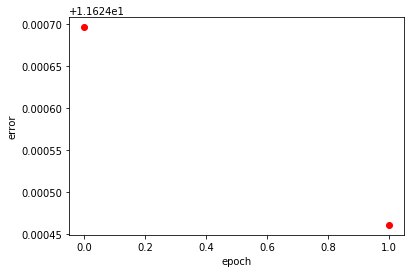

Plotting results


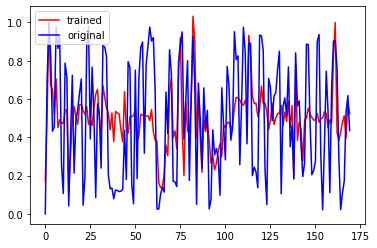

current error:  12.265492145801282
0.22019520883754
[12.26549215]
current error:  12.26507875253218
0.22019469618758963
[12.26549215 12.26507875]
Plotting errors


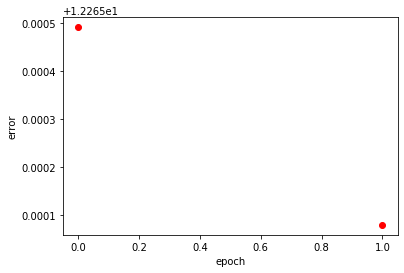

Plotting results


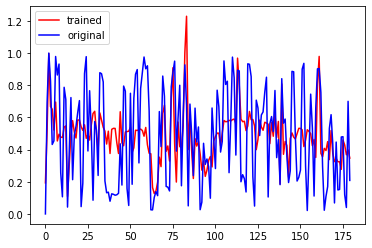

current error:  12.686789846103357
0.21663648347907352
[12.68678985]
current error:  12.686672275694281
0.21663666573191545
[12.68678985 12.68667228]
Plotting errors


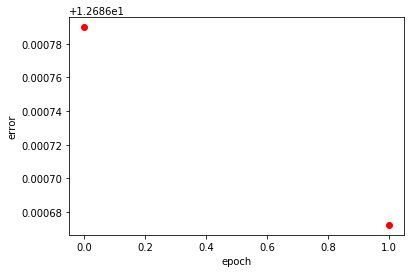

Plotting results


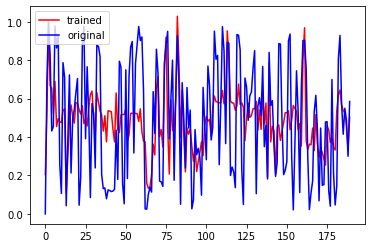

current error:  13.331389424532244
0.2164761182767746
[13.33138942]
current error:  13.331218258240273
0.21647609528218406
[13.33138942 13.33121826]
Plotting errors


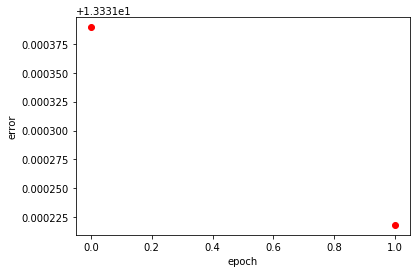

Plotting results


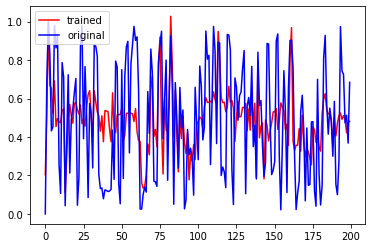

current error:  13.824891609872902
0.21451065092357752
[13.82489161]
current error:  13.824741627356277
0.21451041515661254
[13.82489161 13.82474163]
Plotting errors


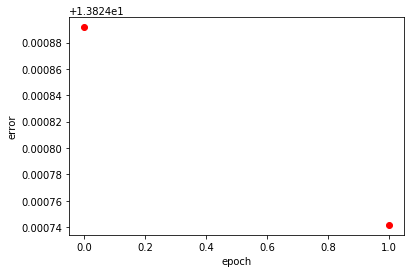

Plotting results


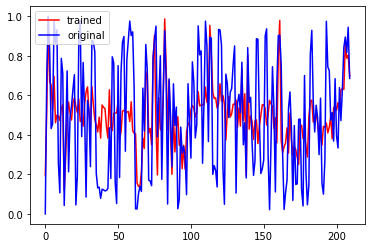

current error:  14.360536918721476
0.21372077696043354
[14.36053692]
current error:  14.360413397402803
0.21372185465883795
[14.36053692 14.3604134 ]
Plotting errors


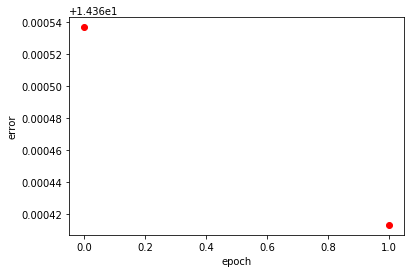

Plotting results


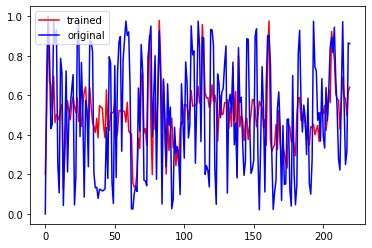

current error:  14.97120647230491
0.213825096213093
[14.97120647]
current error:  14.97110784852345
0.21382661802713035
[14.97120647 14.97110785]
Plotting errors


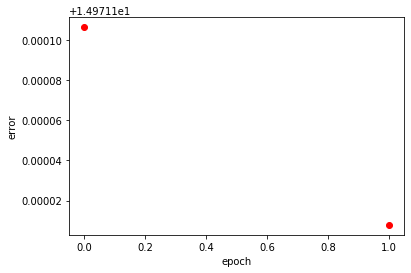

Plotting results


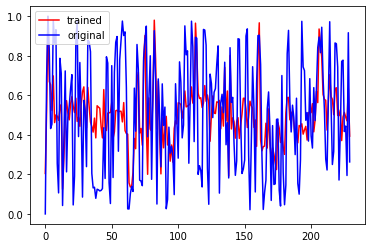

current error:  15.666168645703394
0.21471603149877325
[15.66616865]
current error:  15.665990603880449
0.21471708710569767
[15.66616865 15.6659906 ]
Plotting errors


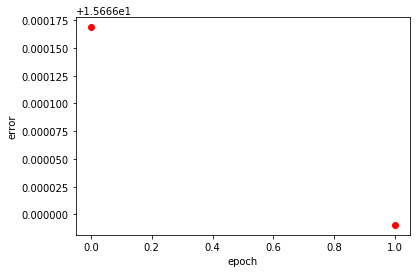

Plotting results


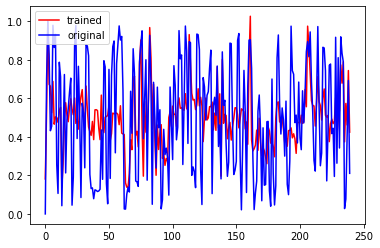

current error:  16.584442995696186
0.21525671972712634
[16.584443]
current error:  16.584196290452024
0.21525772154326603
[16.584443   16.58419629]
Plotting errors


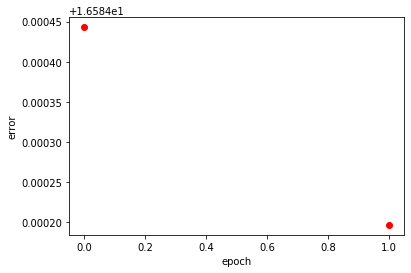

Plotting results


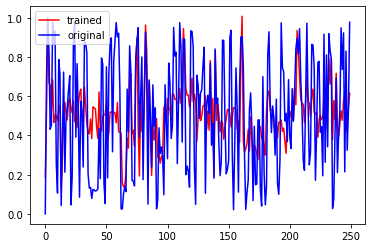

current error:  17.05740631085076
0.21389321198445566
[17.05740631]
current error:  17.057207115990984
0.2138959371967066
[17.05740631 17.05720712]
Plotting errors


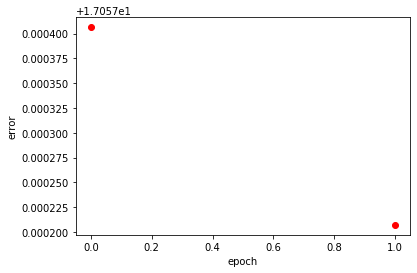

Plotting results


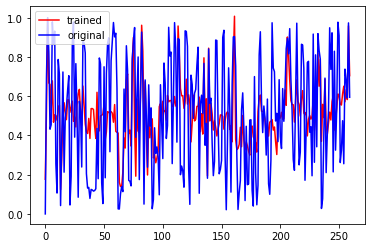

current error:  17.484918816814687
0.21359832026626446
[17.48491882]
current error:  17.484780522399483
0.21359934316977228
[17.48491882 17.48478052]
Plotting errors


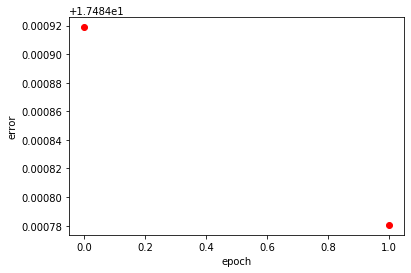

Plotting results


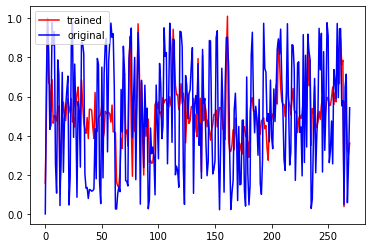

current error:  18.388398564768547
0.21643115925221898
[18.38839856]
current error:  18.381447853898727
0.21639001027912677
[18.38839856 18.38144785]
Plotting errors


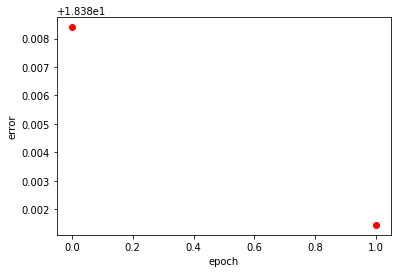

Plotting results


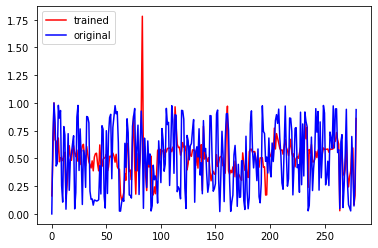

current error:  19.19722766201847
0.21691536437557854
[19.19722766]
current error:  19.19272949924703
0.21688824851104518
[19.19722766 19.1927295 ]
Plotting errors


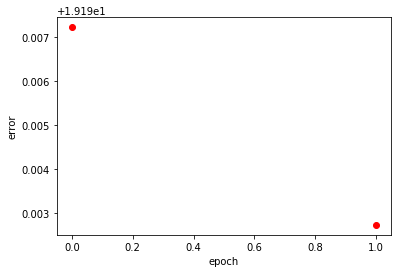

Plotting results


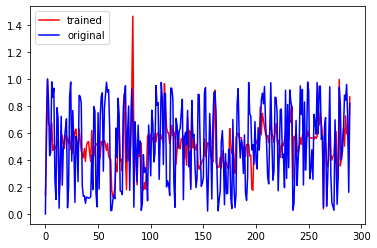

current error:  19.55734636251567
0.21468557728661808
[19.55734636]
current error:  19.55474313157353
0.21466691383287687
[19.55734636 19.55474313]
Plotting errors


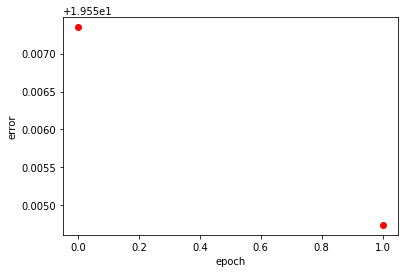

Plotting results


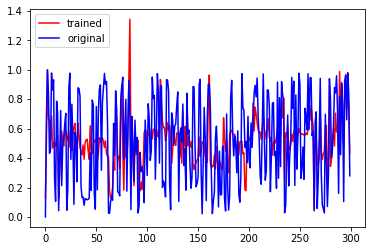

current error:  20.16921255710318
0.2143479923043534
[20.16921256]
current error:  20.163685739168688
0.2143140281221268
[20.16921256 20.16368574]
Plotting errors


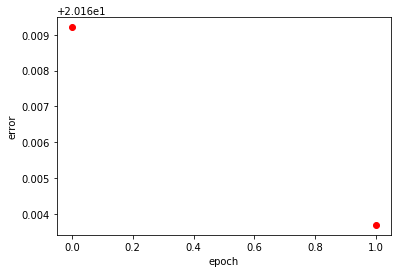

Plotting results


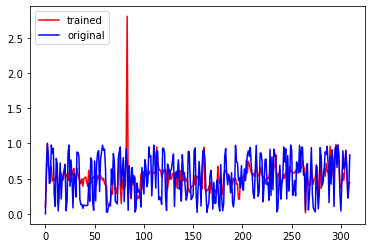

In [31]:
# by run i understood that only when no. of row is equal to 40 my error is increasing
# else its fine So, if i take no. of row above 50, my error will always be decreasing
for i in range(10,320,10):
    X=unique_dataset[['HR','RESP','handGSR']]
    X=X.iloc[:i,:]
    Y=unique_dataset.iloc[:i,10]
    anf = ANFIS(X, Y, mfc)
    anf.trainHybridJangOffLine(epochs=3)

    print("Plotting errors")
    anf.plotErrors()
    print("Plotting results")
    anf.plotResults()